# Import relevant libraries

In [12]:
import psycopg2
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

# Generate mock historical data 

In [2]:
hist_data = {
            "year_month": ["2021-01-01",
                           "2021-02-01",
                           "2021-03-01",
                           "2021-04-01",
                           "2021-05-01",
                           "2021-06-01",
                           "2021-07-01",
                           "2021-08-01",
                           "2021-09-01",
                           "2021-10-01",
                           "2021-11-01",
                           "2021-12-01"],
                "aws_sales": [101,
                              205,
                              145,
                              470,
                              392,
                              843,
                              599,
                              1234,
                              746,
                              2878,
                              3623,
                              10000]
                }

# Fit the HW exponential smoothing

In [ ]:
fitted_model = ExponentialSmoothing(hist_data['aws_sales'],trend='add',seasonal='mul',seasonal_periods=2).fit()

test_predictions = fitted_model.forecast(3)
print(test_predictions)

test = {
            "year_month": ["2022-05-01","2022-06-01","2022-07-01"],
                "aws_sales": test_predictions+max(hist_data['aws_sales']),
                "value_is": ['Prediction','Prediction','Prediction']

                }

# Append predictions to dataframe and connect to Postgres

In [ ]:
test['aws_sales'] = test['aws_sales'].astype('int')
print("Predictions")
print(test)

try:
    conn=psycopg2.connect("dbname='<dbname>' user='<user>' password='<pwd>'")
    print("Connected.")
except:
    print("Not Connected.")



cur = conn.cursor()

# Display current table results

In [19]:
try:
        data = pd.read_sql_query("select * from dim_aws_rev",conn)
        print("Rows fetched.")
        print(data)

except:
        print("Failed fetch.")

Rows fetched.
    year_month  aws_sales value_is
0   2022-01-01      10000   Actual
1   2022-02-01       8705   Actual
2   2022-03-01      12393   Actual
3   2022-04-01       9899   Actual
4   2022-05-01      16902   Actual
5   2021-01-01        101   Actual
6   2021-02-01        205   Actual
7   2021-03-01        145   Actual
8   2021-04-01        470   Actual
9   2021-05-01        392   Actual
10  2021-06-01        843   Actual
11  2021-07-01        599   Actual
12  2021-08-01       1234   Actual
13  2021-09-01        746   Actual
14  2021-10-01       2878   Actual
15  2021-11-01       3623   Actual
16  2021-12-01      10000   Actual


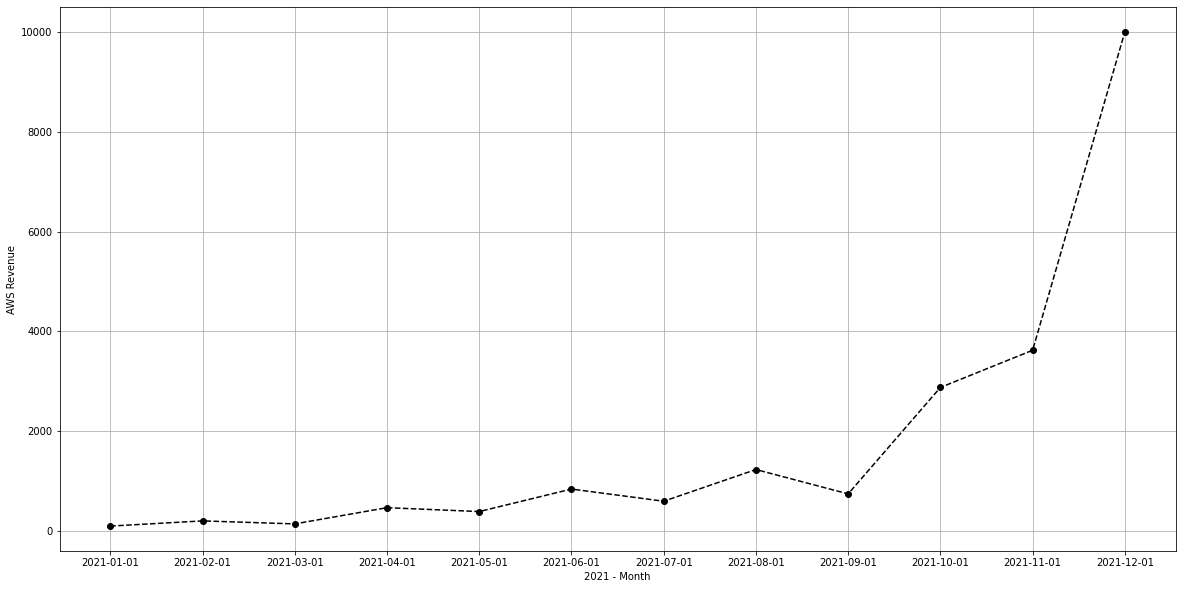

In [33]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.xlabel("2021 - Month")
plt.ylabel("AWS Revenue")
plt.grid()
plt.plot(hist_data['year_month'],hist_data['aws_sales'],'ko--')

# Update the results in Postgres table

In [20]:
test = pd.DataFrame.from_dict(test)
engine = create_engine('postgresql://<user>:<pwd>@localhost:<port>/<dbname>')
test.to_sql(
    name="dim_aws_rev",
    con=engine,
    if_exists="append",
    index=False
    )

3

# Query new results and plot

In [25]:
try:
        data = pd.read_sql_query("select * from dim_aws_rev order by year_month asc",conn)
        print("Rows fetched.")
        print(data)

except:
        print("Failed fetch.")


Rows fetched.
    year_month  aws_sales    value_is
0   2021-01-01        101      Actual
1   2021-02-01        205      Actual
2   2021-03-01        145      Actual
3   2021-04-01        470      Actual
4   2021-05-01        392      Actual
5   2021-06-01        843      Actual
6   2021-07-01        599      Actual
7   2021-08-01       1234      Actual
8   2021-09-01        746      Actual
9   2021-10-01       2878      Actual
10  2021-11-01       3623      Actual
11  2021-12-01      10000      Actual
12  2022-01-01      10000      Actual
13  2022-02-01       8705      Actual
14  2022-03-01      12393      Actual
15  2022-04-01       9899      Actual
16  2022-05-01      16902      Actual
17  2022-05-01      17213  Prediction
18  2022-06-01      26615  Prediction
19  2022-07-01      20800  Prediction


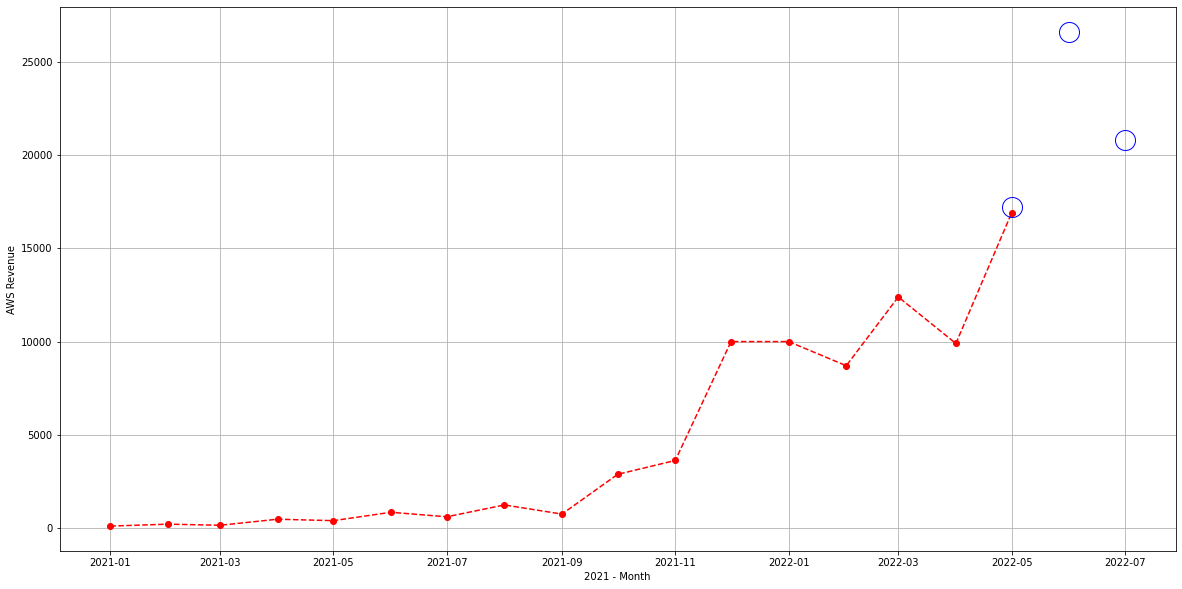

In [34]:
data_act = data[data['value_is'] == 'Actual']
data_pred = data[data['value_is'] == 'Prediction']


plt.rcParams['figure.figsize'] = [20, 10]
plt.xlabel("2021 - Month")
plt.ylabel("AWS Revenue")
plt.grid()
plt.plot(data_act['year_month'],data_act['aws_sales'],'ro--')
plt.plot(data_pred['year_month'],data_pred['aws_sales'],'bo',markerfacecolor='none',ms=20)